In [ ]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
! pip install 
!pip install stable-baselines3[extra]

In [ ]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy



In [ ]:
NUM_ROWS = 6
NUM_COLS = 7
NUM2WIN = 4

In [ ]:
class CustumEnv(Env):
    NUM_ROWS = 6
    NUM_COLS = 7
    NUM2WIN = 4
    def __init__(self):
        # Actions we can take: throw the rock in one of the 7 column
        self.action_space = Discrete(NUM_COLS)
        # state matrix
        self.observation_space = Box(low=np.array([-1 for i in range(7*6)]).reshape(6,7), 
                                     high=np.array([1 for i in range(7*6)]).reshape(6,7),
                                     dtype=np.int8)
        # starting borad matrix
        self.state = np.zeros((6,7))
        
    def step(self, action,player=-1): 
        #action=column number
        # Apply action
        # throw the rock on the top of the existing/empty selected column
        j = 0
        #print("Before Action")
        #print(self.state)
        #print(self.state)
        while j + 1 < self.NUM_ROWS and self.state[j + 1][action] == 0:
            j += 1
        self.state[j][action] = player
        #print("After Action")
        #print(self.state)
    
        winner=""
        # reward
        done = False
        reward = 0
        for i in range(self.NUM_ROWS - self.NUM2WIN + 1):
            for j in range(self.NUM_COLS - self.NUM2WIN + 1):
                sub_state = self.state[i:i + self.NUM2WIN, j:j + self.NUM2WIN]
                if np.max(np.sum(sub_state, axis=0)) == self.NUM2WIN or np.max(np.sum(sub_state, axis=1)) == self.NUM2WIN or np.trace(sub_state) == self.NUM2WIN or np.trace(np.transpose(sub_state)) == self.NUM2WIN: # human having 4 consecutive pieces in a column or row or both diagonals
                    done = True
                    reward = -10
                    winner="Human"
                elif np.min(np.sum(sub_state, axis=0)) == -self.NUM2WIN or np.min(np.sum(sub_state, axis=1)) == -self.NUM2WIN or np.trace(sub_state) == -self.NUM2WIN or np.trace(np.transpose(sub_state)) == -self.NUM2WIN:
                    done = True
                    reward = 10
                    winner="Agent"
                
        if -np.max(np.sum(self.state, axis=0))==np.sum(self.state[:][action%4]) and not done:
                  reward=1   
        elif not done:
                  reward=-1

                
        
        info = {}
        info["winner"]=winner
        
        # Return step information
        return self.state, reward, done,info
    
    def reset(self):
        # Reset
        self.state = np.zeros((6,7))
        return self.state

In [ ]:
env = CustumEnv()

In [ ]:
env.reset()

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
from stable_baselines3.common.env_checker import check_env

In [ ]:
check_env(env,warn=True)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "


In [ ]:
episodes = 20
n_wins=0
for episode in range(1, episodes+1):
    current_state = env.reset()
    done = False
    score = 0 
    human_play=True
    while not done:
        if human_play:
          env.step(np.random.choice(np.arange(0,7)))
          print("Random is playing: ")
          human_play=False
          print("Current State:")
          print(current_state) 
          continue
        else: 
          print("Agent is playing: ")
          action = env.action_space.sample()
          
          current_state, reward, done, info = env.step(action)
          print("Current action is: ",action)
          print("Collected reward is: ",reward)
          score+=reward
          print("Current State:")
          print(current_state)  
          human_play=True
    if done:
      print("Game was done at episode {} with a score of {}".format(episode,score))   
      if info["winner"]=="Agent":
        n_wins+=1   
    print('Episode:{} Score:{}'.format(episode, score))



Random is playing: 
Current State:
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
Agent is playing: 
Current action is:  4
Collected reward is:  -1
Current State:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.]]
Random is playing: 
Current State:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  1.]]
Agent is playing: 
Current action is:  2
Collected reward is:  -1
Current State:
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  1.  1.]]
Random is playing: 
Current State:
[[ 0.  0.  0.  0.  0.  0.  

In [ ]:
model = PPO("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.63     |
|    ep_rew_mean     | 17       |
| time/              |          |
|    fps             | 351      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.71        |
|    ep_rew_mean          | 17.4        |
| time/                   |             |
|    fps                  | 297         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011472172 |
|    clip_fraction        | 0.0929      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.0165     |
|    learning_rate        | 0.

In [ ]:
episodes = 20
n_wins=0
for episode in range(1, episodes+1):
    current_state = env.reset()
    done = False
    score = 0 
    human_play=True
    while not done:
        if human_play:
          env.step(np.random.choice(np.arange(0,7)),1)
          #print("Random is playing: ")
          human_play=False
          #print("Current State:")
          #print(current_state) 
          continue
        else: 
          #print("Agent is playing: ")
          action = model.predict(current_state)[0]
          current_state, reward, done, info = env.step(action,-1)
          #print("Current action is: ",action)
          #print("Collected reward is: ",reward)
          score+=reward
          #print("Current State:")
          #print(current_state)  
          human_play=True
    if done:
      print("Game was done at episode {} with a score of {}".format(episode,score))   
      if info["winner"]=="Agent":
        n_wins+=1   
    print('Episode:{} Score:{}'.format(episode, score))



Game was done at episode 1 with a score of -29
Episode:1 Score:-29
Game was done at episode 2 with a score of -24
Episode:2 Score:-24
Game was done at episode 3 with a score of -32
Episode:3 Score:-32
Game was done at episode 4 with a score of -7
Episode:4 Score:-7
Game was done at episode 5 with a score of 9
Episode:5 Score:9
Game was done at episode 6 with a score of -18
Episode:6 Score:-18
Game was done at episode 7 with a score of -30
Episode:7 Score:-30
Game was done at episode 8 with a score of -57
Episode:8 Score:-57
Game was done at episode 9 with a score of -15
Episode:9 Score:-15
Game was done at episode 10 with a score of 4
Episode:10 Score:4
Game was done at episode 11 with a score of -19
Episode:11 Score:-19
Game was done at episode 12 with a score of 8
Episode:12 Score:8
Game was done at episode 13 with a score of -27
Episode:13 Score:-27
Game was done at episode 14 with a score of -23
Episode:14 Score:-23
Game was done at episode 15 with a score of -16
Episode:15 Score:-

In [ ]:
print("Total iterations won by agent is: {}".format(n_wins))

Total iterations won by agent is: 4


In [3]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

In [4]:
NUM_ROWS = 6
NUM_COLS = 7
NUM2WIN = 4

In [5]:
class CustumEnv(Env):
    NUM_ROWS = 6
    NUM_COLS = 7
    NUM2WIN = 4
    def __init__(self):
        # Actions we can take: throw the rock in one of the 7 column
        self.action_space = Discrete(NUM_COLS)
        # state matrix
        self.observation_space = Box(low=np.array([-1 for i in range(7*6)]).reshape(6,7), 
                                     high=np.array([1 for i in range(7*6)]).reshape(6,7),
                                     dtype=np.int8)
        # starting borad matrix
        self.state = np.zeros((6,7))
        
    def step(self, action,player): 
        #action=column number
        # Apply action
        # throw the rock on the top of the existing/empty selected column
        j = 0
        #print("Before Action")
        #print(self.state)
        #print(self.state)
        while j + 1 < self.NUM_ROWS and self.state[j + 1][action] == 0:
            j += 1
        info = {}    
        if self.state[j][action]!=0:
          self.state[j][action]!=np.nan
          reward=-10000
          done=True
          winner="overflow"
          info["winner"]=winner
          return self.state,reward,done,info
        self.state[j][action] = player
        #print("After Action")
        #print(self.state)

        winner=""
        # reward
        done = False
        reward = 0
        for i in range(self.NUM_ROWS - self.NUM2WIN + 1):
            for j in range(self.NUM_COLS - self.NUM2WIN + 1):
                sub_state = self.state[i:i + self.NUM2WIN, j:j + self.NUM2WIN]
                if np.max(np.sum(sub_state, axis=0)) == self.NUM2WIN or np.max(np.sum(sub_state, axis=1)) == self.NUM2WIN or np.trace(sub_state) == self.NUM2WIN or np.trace(np.transpose(sub_state)) == self.NUM2WIN: # human having 4 consecutive pieces in a column or row or both diagonals
                    done = True
                    reward = -10
                    winner="Human"
                elif np.min(np.sum(sub_state, axis=0)) == -self.NUM2WIN or np.min(np.sum(sub_state, axis=1)) == -self.NUM2WIN or np.trace(sub_state) == -self.NUM2WIN or np.trace(np.transpose(sub_state)) == -self.NUM2WIN:
                    done = True
                    reward = 10
                    winner="Agent"
                
        if -np.max(np.sum(self.state, axis=0))==np.sum(self.state[:,action]) and not done:
                  reward=1   
        elif not done:
                  reward=-1

                
        
        
        info["winner"]=winner
        
        # Return step information
        return self.state, reward, done,info
    
    def reset(self):
        # Reset
        self.state = np.zeros((6,7))
        return self.state

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = CustumEnv()
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(7)
State space: Box(-1, 1, (6, 7), int8)


In [7]:
# An episode a full game
train_episodes = 250
test_episodes = 100

def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    #print("state_shape: ",state_shape)
    #print("action shape: ",action_shape)
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(48, input_shape=state_shape, activation='relu', kernel_initializer=init,))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu', kernel_initializer=init,
    kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=keras.regularizers.l2(1e-4),
    activity_regularizer=keras.regularizers.l2(1e-5)))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    return model

def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]

def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7 # Learning rate
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    env.reset()
    batch_size = 64 * 2
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        try:
          current_qs[:,action] = (1 - learning_rate) * current_qs[:,action] + learning_rate * max_future_q
        except:
          print(action)
          print(current_qs.shape)
        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [8]:
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01

# 1. Initialize the Target and Main models
# Main Model (updated every 4 steps)
model = agent(env.observation_space.shape, env.action_space.n)
# Target Model (updated every 100 steps)
target_model = agent(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)

target_update_counter = 0

# X = states, y = actions
X = []
y = []

steps_to_update_target_model = 0
n_wins=0
train_list_performace=[]
for episode in range(train_episodes):
    total_training_rewards = 0
    observation = env.reset()
    done = False
    human_play=True
    stop=100
    
    while not done:
        if human_play:
          action = np.random.choice(np.arange(0,7))
          env.step(action,1)
          human_play=False  
        
        else:
          stop-=1
          steps_to_update_target_model += 1
          human_play=True
          random_number = np.random.rand()
          # 2. Explore using the Epsilon Greedy Exploration Strategy
          if random_number <= epsilon:
              # Explore
              action = env.action_space.sample()
              print("Taking a random walk")
          else:
              # Exploit best known action
              # model dims are (batch, env.observation_space.n)
              encoded = observation
              #encoded_reshaped = encoded.reshape(1,encoded_reshaped[0],encoded_reshaped[1],1)
              #print(encoded_reshaped.shape)
              predicted = model.predict(observation)
              #print("predicted: ",predicted.shape)
              action = predicted.argmax(axis=1)[1]
              #print("action: ",action)
          temp=env.state   
          new_observation, reward, done, info = env.step(action,-1)
          if info["winner"]=="overflow":
            l=[i for i in range(env.action_space.n)]
            l.remove(action)

            action=np.random.choice(l)
            new_observation, reward, done, info = env.step(action,-1)
          if (temp==new_observation).all() and stop==-1:
            print("Action that was taken is: ",action)
            print(temp)
            print(new_observation)
          replay_memory.append([observation, action, reward, new_observation, done])

          # 3. Update the Main Network using the Bellman Equation
          if steps_to_update_target_model % 4 == 0 or done:
              train(env, replay_memory, model, target_model, done)

          observation = new_observation
          total_training_rewards += reward

          if done:
              print('Total training rewards: {} after n steps = {} with final reward = {} with a winner :{}'.format(total_training_rewards, episode, reward,info["winner"]))
              if info["winner"]=="Agent":
                n_wins+=1
              else:
                n_wins=max(n_wins-1,0) 
              train_list_performace.append(n_wins)   
              total_training_rewards += 1

              if steps_to_update_target_model >= 100:
                  print('Copying main network weights to the target network weights')
                  target_model.set_weights(model.get_weights())
                  steps_to_update_target_model = 0
              break
          else:
            print("Training at epoch = {}, with a reward {}".format(episode,reward))
        
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()

Taking a random walk
Training at epoch = 0, with a reward 1
Taking a random walk
Training at epoch = 0, with a reward 1
Taking a random walk
Training at epoch = 0, with a reward 1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward -1
Taking a random walk
Training at epoch = 0, with a reward 1
Taking a random walk
Training at epoch = 0, with a reward 1
Taking a random walk
Total training rewards: 9 after n steps = 0 with final reward = 10 with a winner :Agent
Taking a random walk
Training at epoch = 1, with a reward 1
Taking a random walk
Training at epoch = 1, with a reward -1
Taking a random walk
Training at epoch = 1, with a reward -1
Taking a random walk
Training at epoch = 1,

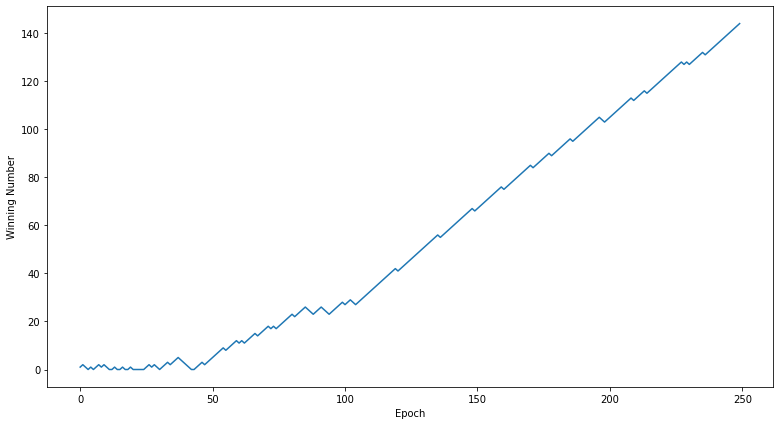

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,7))
plt.xlabel("Epoch")
plt.ylabel("Winning Number")
plt.plot(range(0,len(train_list_performace)),train_list_performace)

In [10]:
episodes = 20
n_wins=0
for episode in range(1, episodes+1):
    current_state = env.reset()
    done = False
    score = 0 
    human_play=True
    while not done:
        if human_play:
          env.step(np.random.choice(np.arange(0,7)),1)
          #print("Random is playing: ")
          human_play=False
          #print("Current State:")
          #print(current_state) 
          continue
        else: 
          #print("Agent is playing: ")
          action = model.predict(current_state)
          action = predicted.argmax(axis=1)[1]
          current_state, reward, done, info = env.step(action,-1)
          #print("Current action is: ",action)
          #print("Collected reward is: ",reward)
          score+=reward
          #print("Current State:")
          #print(current_state)  
          human_play=True
    if done:
      print("Game was done at episode {} with a score of {}".format(episode,score))   
      if info["winner"]=="Agent":
        n_wins+=1   
    print('Episode:{} Score:{}'.format(episode, score))

print("Total iterations won by agent is: {}".format(n_wins))

Game was done at episode 1 with a score of -10000
Episode:1 Score:-10000
Game was done at episode 2 with a score of 9
Episode:2 Score:9
Game was done at episode 3 with a score of 9
Episode:3 Score:9
Game was done at episode 4 with a score of -9998
Episode:4 Score:-9998
Game was done at episode 5 with a score of -10002
Episode:5 Score:-10002
Game was done at episode 6 with a score of 9
Episode:6 Score:9
Game was done at episode 7 with a score of -10003
Episode:7 Score:-10003
Game was done at episode 8 with a score of 10
Episode:8 Score:10
Game was done at episode 9 with a score of 9
Episode:9 Score:9
Game was done at episode 10 with a score of -11
Episode:10 Score:-11
Game was done at episode 11 with a score of 9
Episode:11 Score:9
Game was done at episode 12 with a score of 9
Episode:12 Score:9
Game was done at episode 13 with a score of 9
Episode:13 Score:9
Game was done at episode 14 with a score of 11
Episode:14 Score:11
Game was done at episode 15 with a score of 9
Episode:15 Score

In [11]:
model.save("DQN_C4.h5")

In [12]:
env.action_space.n

7

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6, 48)             384       
_________________________________________________________________
dropout (Dropout)            (None, 6, 48)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 16)             784       
_________________________________________________________________
dense_2 (Dense)              (None, 6, 7)              119       
Total params: 1,287
Trainable params: 1,287
Non-trainable params: 0
_________________________________________________________________
